In [58]:
import pandas as pd
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### 1. ĐỊNH NGHĨA CÁC HÀM XỬ LÝ DỮ LIỆU & FEATURE ENGINEERING

In [59]:

# Feature 1: Shophouse (Dựa trên link)
def extract_shophouse(link):
    return 1 if 'shophouse' in str(link).lower() else 0

# Feature 2: Từ khóa cao cấp (Dựa trên title và link)
def extract_luxury_keywords(title, link):
    text = str(title).lower() + ' ' + str(link).lower()
    keywords = ['villa', 'biet-thu', 'duplex', 'penthouse', 'mansion']
    if any(k in text for k in keywords):
        return 1
    return 0

# Feature 3: Gara hoặc Thang máy (Dựa trên title)
def extract_garage_or_elevator(title):
    text = str(title).lower()
    keywords = ['thang máy', 'thang may', 'gara', 'auto']
    if any(k in text for k in keywords):
        return 1
    return 0


### 2. TẢI DỮ LIỆU & TIỀN XỬ LÝ FEATURE

In [60]:
file_path = 'batdongsan_data_no_outliers.csv'
df = pd.read_csv(file_path) # Tải dữ liệu từ file CSV

# Tạo Feature Engineering cho các biến nhị phân
df['is_shophouse'] = df['link'].apply(extract_shophouse)
df['is_luxury_keyword'] = df.apply(lambda row: extract_luxury_keywords(row['title'], row['link']), axis=1)
df['has_garage_or_elevator'] = df['title'].apply(lambda x: extract_garage_or_elevator(x) if pd.notna(x) else 0)

# Feature Engineering: Price per m2
df['area_m2_safe'] = df['area_m2'].replace(0, np.nan)
df['price_per_m2'] = df['price_ty'] / df['area_m2_safe']
median_price_per_m2 = df['price_per_m2'].median()
df['price_per_m2'] = df['price_per_m2'].fillna(median_price_per_m2)

# Xử lý District (Điền giá trị thiếu bằng Mode/Unknown cho mã hóa)
if df['district'].mode().empty:
    df['district'] = df['district'].fillna('Unknown')
else:
    df['district'] = df['district'].fillna(df['district'].mode()[0])

# Định nghĩa các cột sử dụng
numerical_features = ['price_ty', 'area_m2', 'bedrooms_num', 'toilets_num', 'price_per_m2', 
                      'is_shophouse', 'is_luxury_keyword', 'has_garage_or_elevator']
categorical_features = ['district']
target_col = 'loai_bds'

# Lọc bỏ lớp "Khong_Ro" (các mẫu không thể phân loại)
data_for_model = df[numerical_features + categorical_features + [target_col]].dropna().copy()
data_for_model = data_for_model[data_for_model[target_col] != 'Khong_Ro'] 

X = data_for_model[numerical_features + categorical_features]
y = data_for_model[target_col]

### 3. PIPELINE TIỀN XỬ LÝ (SCALE cho số, OHE cho Quận/Huyện)

In [61]:
# Preprocessor: Scale cho cột số, OHE cho cột phân loại
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features), # Bắt buộc cho KNN
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # OHE cho District
    ])

### 4. CHIA TẬP DỮ LIỆU & HUẤN LUYỆN MÔ HÌNH KNN 

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

optimal_k = 6
# Tạo Pipeline cho KNN: Tiền xử lý -> Huấn luyện
knn_model_final = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier(n_neighbors=optimal_k))])

# Huấn luyện mô hình
knn_model_final.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['price_ty', 'area_m2',
                                                   'bedrooms_num',
                                                   'toilets_num',
                                                   'price_per_m2',
                                                   'is_shophouse',
                                                   'is_luxury_keyword',
                                                   'has_garage_or_elevator']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['district'])])),
                ('classifier', KNeighborsClassifier(n_neighbors=6))])

### Dự đoán và đánh giá

In [64]:
y_pred_improved = knn_model_final.predict(X_test)
accuracy_improved = accuracy_score(y_test, y_pred_improved)
print("=========================================================")
print(f"Độ chính xác (Accuracy) của mô hình KNN (K={optimal_k})")
print("=========================================================")
print(classification_report(y_test, y_pred_improved))

Độ chính xác (Accuracy) của mô hình KNN (K=6)
                  precision    recall  f1-score   support

Biệt thự/Liền kề       0.96      0.97      0.97        80
 Căn hộ chung cư       0.87      0.93      0.90       183
  Nhà riêng/Khác       0.90      0.90      0.90       154
  Đất nền/Thổ cư       0.88      0.76      0.82        96

        accuracy                           0.89       513
       macro avg       0.90      0.89      0.90       513
    weighted avg       0.89      0.89      0.89       513



In [65]:

# Chuẩn bị dữ liệu cho trực quan hóa
X_test_original_improved = X_test.copy()
X_test_original_improved['Predicted_BDS'] = y_pred_improved
X_test_original_improved['Actual_BDS'] = y_test

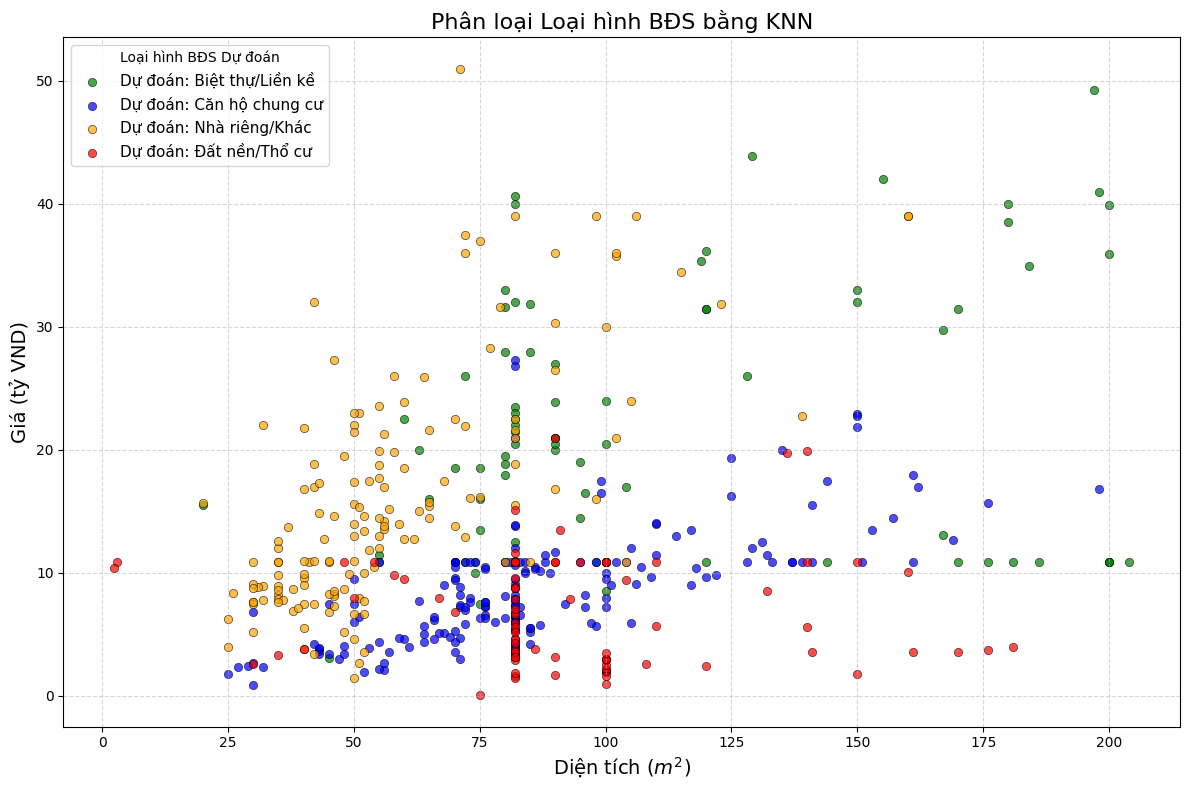

In [66]:
plt.figure(figsize=(12, 8))

# Định nghĩa màu sắc cho mỗi lớp
colors = {'Căn hộ chung cư': 'blue', 'Biệt thự/Liền kề': 'green', 'Đất nền/Thổ cư': 'red', 'Nhà riêng/Khác': 'orange'}

# Vẽ các điểm dữ liệu dự đoán
for name, group in X_test_original_improved.groupby('Predicted_BDS'):
    if name != 'Khong_Ro':
        plt.scatter(group['area_m2'], group['price_ty'], 
                    label=f'Dự đoán: {name}',
                    color=colors.get(name, 'gray'),
                    alpha=0.7,
                    edgecolors='k', 
                    linewidth=0.5)

plt.title(f'Phân loại Loại hình BĐS bằng KNN', fontsize=16)
plt.xlabel('Diện tích ($m^2$)', fontsize=14)
plt.ylabel('Giá (tỷ VND)', fontsize=14)
plt.legend(fontsize=11, title='Loại hình BĐS Dự đoán')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Lưu biểu đồ
output_path_knn = os.path.join("img", "KNN.png")
plt.savefig(output_path_knn, dpi=300, bbox_inches="tight")
plt.show()

### 6. TRỰC QUAN HÓA MA TRẬN NHẦM LẪN

<Figure size 1000x800 with 0 Axes>

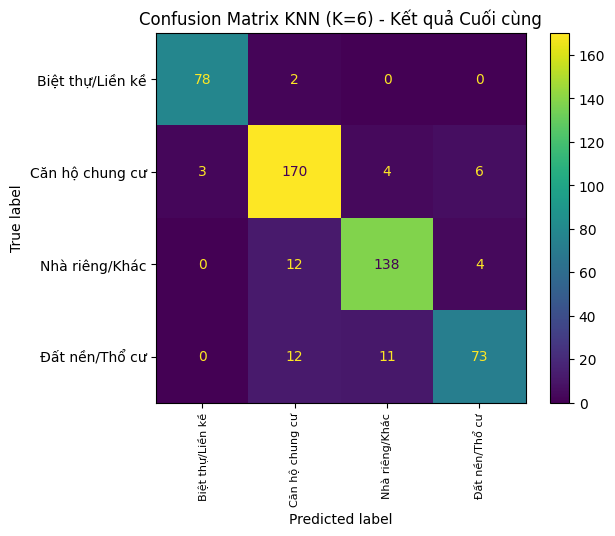

In [67]:
# --- 6. TRỰC QUAN HÓA MA TRẬN NHẦM LẪN ---
if not os.path.exists("img"):
    os.makedirs("img")

plt.figure(figsize=(10, 8))
# Dùng pipeline để tự động tiền xử lý dữ liệu trước khi vẽ Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_model_final, X_test, y_test, cmap='viridis', 
                                      xticks_rotation='vertical', values_format='d') 
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.title(f"Confusion Matrix KNN (K={optimal_k}) - Kết quả Cuối cùng")

output_path_cm = os.path.join("img", "Confusion_Matrix_KNN_Final.png")
plt.savefig(output_path_cm, dpi=300, bbox_inches="tight")
plt.show()

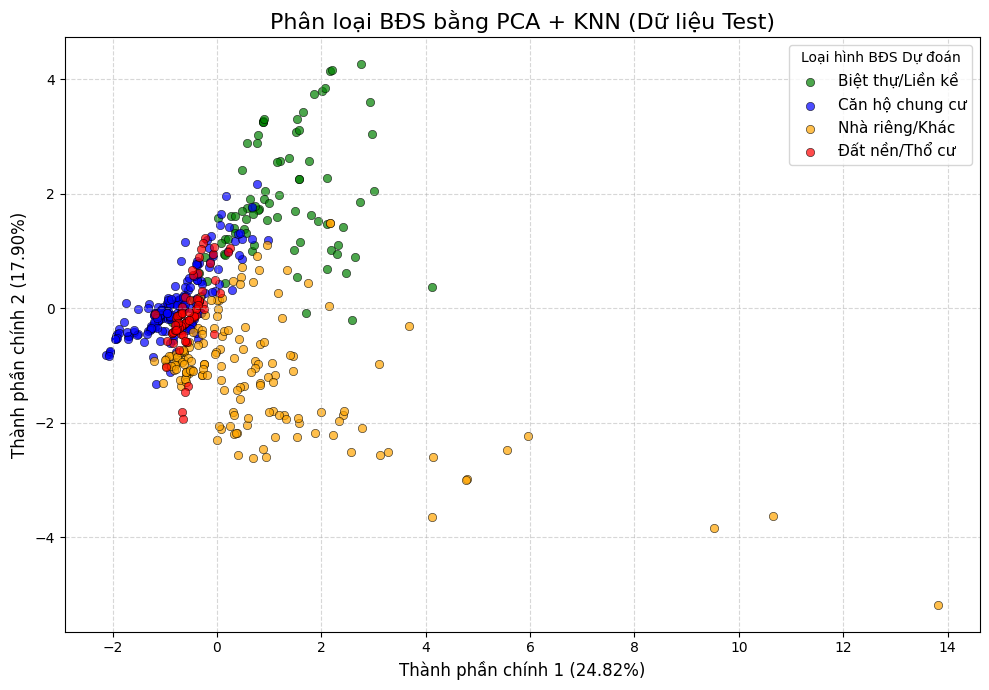

In [73]:
# Bước 1a: Áp dụng tất cả các bước tiền xử lý (Scaling + OHE) lên X_train
X_train_processed = knn_model_final.named_steps['preprocessor'].transform(X_train)

# Bước 1b: Áp dụng tất cả các bước tiền xử lý (Scaling + OHE) lên X_test
X_test_processed = knn_model_final.named_steps['preprocessor'].transform(X_test)


# --- 2. ÁP DỤNG PCA ---

pca_new = PCA(n_components=2, random_state=42)

# Fit PCA trên TẬP HUẤN LUYỆN đã được tiền xử lý
pca_new.fit(X_train_processed)

# Transform TẬP KIỂM THỬ đã được tiền xử lý
X_test_pca_new = pca_new.transform(X_test_processed)

# --- 3. VẼ BIỂU ĐỒ (CHỈ SỬ DỤNG DỮ LIỆU TEST) ---

# Định nghĩa màu sắc (Giả định colors đã được định nghĩa)
colors = {'Căn hộ chung cư': 'blue', 'Biệt thự/Liền kề': 'green', 
          'Đất nền/Thổ cư': 'red', 'Nhà riêng/Khác': 'orange'} 
# Dùng y_pred (kết quả dự đoán trên tập test) để đánh giá phân loại

plt.figure(figsize=(10, 7))
# Dùng y_pred (là kết quả dự đoán trên tập test) để phân nhóm dữ liệu
unique_classes = np.unique(y_pred_improved)

for name in unique_classes:
    # Lọc các chỉ mục (index) trong tập test mà mô hình dự đoán là 'name'
    idx = (y_pred_improved == name) 
    
    if name != 'Khong_Ro':
        plt.scatter(X_test_pca_new[idx, 0], X_test_pca_new[idx, 1], 
                    label=name, 
                    alpha=0.7, 
                    color=colors.get(name, 'gray'), 
                    edgecolors='k', 
                    linewidth=0.5)

plt.title(f"Phân loại BĐS bằng PCA + KNN (Dữ liệu Test)", fontsize=16)
plt.xlabel(f'Thành phần chính 1 ({pca_new.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12)
plt.ylabel(f'Thành phần chính 2 ({pca_new.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12)
plt.legend(title='Loại hình BĐS Dự đoán', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Lưu biểu đồ
output_path_pca_knn = os.path.join("img", "PCA_KNN_Final.png")
plt.savefig(output_path_pca_knn, dpi=300, bbox_inches="tight")
plt.show()

In [87]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import re

# --- 1. TẠO HỒ SƠ BĐS MỚI (PHẢI CÓ TẤT CẢ CÁC FEATURE BAN ĐẦU) ---

new_bds_data = {
    'price_ty': [35.0],      # Giá: 35 tỷ VND
    'area_m2': [100.0],      # Diện tích: 100 m2
    'bedrooms_num': [2.0],   # Số phòng ngủ: 2
    'toilets_num': [2.0],    # Số phòng vệ sinh: 2
    'is_shophouse': [0], 
    'is_luxury_keyword': [1],
    'has_garage_or_elevator': [1], 
    'district': ['Tây Hồ'],  # Feature mới: Quận/Huyện (Bắt buộc phải có)
}
new_bds_df = pd.DataFrame(new_bds_data)

new_bds_df['price_per_m2'] = new_bds_df['price_ty'] / new_bds_df['area_m2']

# Định nghĩa các cột (Phải khớp với thứ tự đã dùng trong Pipeline)
feature_cols_all = ['price_ty', 'area_m2', 'bedrooms_num', 'toilets_num', 'price_per_m2', 
                    'is_shophouse', 'is_luxury_keyword', 'has_garage_or_elevator', 'district']
new_bds_df = new_bds_df[feature_cols_all]

# --- 3. DỰ ĐOÁN SỬ DỤNG PIPELINE VÀ LẤY XÁC SUẤT ---
# 1. Thực hiện dự đoán
predicted_class = knn_model_final.predict(new_bds_df)

# 2. Lấy xác suất dự đoán
proba = knn_model_final.predict_proba(new_bds_df)[0] # Lấy mảng xác suất cho mẫu đầu tiên

# 3. Lấy tên các lớp (classes)
class_names = knn_model_final.classes_

print("\nKẾT QUẢ DỰ ĐOÁN:")
print(f"Loại hình BĐS được dự đoán là: {predicted_class[0]}")
print("Xác suất dự đoán cho từng loại hình BĐS:")
for class_name, probability in zip(class_names, proba):
    print(f" - {class_name}: {probability*100:.2f}%")



KẾT QUẢ DỰ ĐOÁN:
Loại hình BĐS được dự đoán là: Biệt thự/Liền kề
Xác suất dự đoán cho từng loại hình BĐS:
 - Biệt thự/Liền kề: 100.00%
 - Căn hộ chung cư: 0.00%
 - Nhà riêng/Khác: 0.00%
 - Đất nền/Thổ cư: 0.00%


In [69]:
from sklearn.model_selection import GridSearchCV

param_grid = {'classifier__n_neighbors': range(3, 31)}
grid = GridSearchCV(knn_model_final, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best K:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best K: {'classifier__n_neighbors': 6}
Best CV Accuracy: 0.8862782515355716
